# Metrics

## Aim of this Notebook
This Notebook will be used to compute each metric, plotting it and all its related location and variance estimates as well as some helpful plots to help visualize the distribution of the metric over a lot of shifts (aprox 540)

In [1]:
import numpy as np
import pandas as pd
import pendulum as pen
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import PyQt5

In [2]:
# read csv file with integrated pandas function and look at its shape
data = pd.read_csv(
    "/Users/etiennecouque-castelnovo/Documents/Studium/Bachelorarbeit/rscripts/CleanedCSV.csv")
print(data.shape)

(1878376, 14)


## Preparing the dataset
We must pay attention to only select whole shifts in order to avoid false values that represent only half or quarter of a shift, so we cannot pick the first and last few entries since the records start and end at random times. Since the data is ordered by *Zeit* we simply look at the first *Schicht* value change and the last and drop everything before and after.

In [3]:
# Searching first value that differs from the first *Schicht* value
first_shift = data['Schicht'].iloc[0]
last_shift = data['Schicht'].iloc[-1]
# In order to use .argmax() numpy function both times, we flip the dataframe around and count from behind in last_switch
first_switch = (data['Schicht'] != first_shift).argmax()
last_switch = (data[::-1]['Schicht'] != last_shift).argmax()

print("First entry belongs to shift \"{}\", last entry belongs to shift \"{}\"".format(
    first_shift, last_shift))
df = data.iloc[first_switch:-last_switch, :]
print("Succesfully dropped {} entries".format(first_switch+last_switch))
print(df.shape[0])

del first_shift, first_switch, last_shift, last_switch, data

First entry belongs to shift "Spät", last entry belongs to shift "Früh"
Succesfully dropped 9466 entries
1868910


## Exploring the dataset

In [4]:
# Temporary data structure to collect metric over multiple shifts
mean_temp = []

df_mean = df[((df['Schicht'] == 'Früh') | (df['Schicht'] == 'Spät') | (df['Schicht'] == 'Nacht')) & (df['Situation'] == 'generiert')][['Schicht', 'TrueTime']]
current_shift = df_mean['Schicht'].iloc[0]
# Starting index of shift to evaluate
start_idx = 0
# Increment index to count how many entries there are in the shift
inc_idx = (df_mean['Schicht'] != current_shift).argmax()
# End index to mark the end of the observed shift
end_idx = (df_mean['Schicht'] != current_shift).argmax()

# Increment index is 0 when the argmax call fails, or doesnt find what we are looking for. Marks the end of first shift
while(inc_idx != 0):
    # Taking the shift slice out of the dataset
    df_slice = df_mean.iloc[start_idx:end_idx]
    # Appending result (series) to the temporyry datastructure
    mean_temp.append(np.concatenate(
        ([current_shift, df_mean['TrueTime'].iloc[start_idx], df_mean['TrueTime'].iloc[end_idx-1]], np.array([df_slice.shape[0]]))))
    # Updating shift and indices
    current_shift = df_mean['Schicht'].iloc[end_idx]
    start_idx = end_idx
    inc_idx = (df_mean['Schicht'].iloc[start_idx:] != current_shift).argmax()
    end_idx += inc_idx

# After while loop, the last shift must be treated. Not elegantly solved
# Must be implemented as function where slice is passed so there is no repitition
df_slice = df_mean.iloc[start_idx:]
mean_temp.append(np.concatenate(
    ([current_shift, df_mean['TrueTime'].iloc[start_idx], df_mean['TrueTime'].iloc[-1]], np.array([df_slice.shape[0]]))))

# Creating pandas dataframe for the metric and properly setting index
amount = pd.DataFrame(mean_temp, columns=np.concatenate((np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp']), np.array(['amount']))))
# Converting datatypes
amount['amount'] = amount['amount'].astype(int)

print(df_mean.shape[0])
del start_idx, inc_idx, end_idx, current_shift, df_slice, mean_temp, df_mean

277651


In [5]:
amount[amount['Shift'] == 'Nacht']['amount'].describe()

count      90.000000
mean      929.622222
std       312.431550
min       460.000000
25%       728.500000
50%       873.500000
75%      1072.000000
max      1986.000000
Name: amount, dtype: float64

In [6]:
df_amount = df[(df['Schicht'] == 'Früh') | (df['Schicht'] == 'Spät') | (df['Schicht'] == 'Nacht')][['Schicht', 'TrueTime', 'Situation']]
#df_amount = df[(df['Schicht'] == 'Früh')]
df_amounf_sub = df_amount[~(df_amount['Situation'] == 'generiert') & ~(df_amount['Situation'] == 'beendet')]
print(df_amounf_sub.shape[0]/df_amount.shape[0]*100)

68.16853456505498


In [7]:
# Switch plotting mode
#%matplotlib qt
%matplotlib inline

# Alarms per Bed per Shift (APBPS)
Diese einfach zu berechnende Metrik beschriebt wieviele Alarme auf der Station in einer Schicht generiert wurden für jedes einzelne Bett. Die Zahl kann durch 48 geteilt werden um einen Wert pro 10 minuten zu bekommen.

In [8]:
# Temporary data structure to collect metric over multiple shifts
apbpd_temp = []

df_apbps = df[df['Situation'] == 'generiert'][['TrueTime', 'Schicht', 'Bettname']]
df_apbps = df_apbps.sort_values('TrueTime')
current_shift = df_apbps['Schicht'].iloc[0]
# Starting index of shift to evaluate
start_idx = 0
# Increment index to count how many entries there are in the shift
inc_idx = (df_apbps['Schicht'] != current_shift).argmax()
# End index to mark the end of the observed shift
end_idx = (df_apbps['Schicht'] != current_shift).argmax()

# Index used to create pandas dataframe later on
bedindex = np.sort(df["Bettname"].unique())

# Increment index is 0 when the argmax call fails, or doesnt find what we are looking for. Marks the end of first shift
while(inc_idx != 0):
    # Taking the shift slice out of the dataset
    df_slice = df_apbps[['Bettname']].iloc[start_idx:end_idx]
    # Creating a groupby pandas Series and reindexing it so all beds occur in the series
    df_slice_ser = df_slice.groupby("Bettname").size().reindex(
        index=bedindex, fill_value=0).sort_index()
    # Appending result (series) to the temporyry datastructure
    apbpd_temp.append(np.concatenate(
        ([current_shift, df_apbps['TrueTime'].iloc[start_idx], df_apbps['TrueTime'].iloc[end_idx-1]], np.array(df_slice_ser))))
    # Updating shift and indices
    current_shift = df_apbps['Schicht'].iloc[end_idx]
    start_idx = end_idx
    inc_idx = (df_apbps['Schicht'].iloc[start_idx:] != current_shift).argmax()
    end_idx += inc_idx

# After while loop, the last shift must be treated. Not elegantly solved
# Must be implemented as function where slice is passed so there is no repitition
df_slice = df_apbps[['Bettname']].iloc[start_idx:]
df_slice_ser = df_slice.groupby("Bettname").size().reindex(
    index=bedindex, fill_value=0).sort_index()
apbpd_temp.append(np.concatenate(
    ([current_shift, df_apbps['TrueTime'].iloc[start_idx], df_apbps['TrueTime'].iloc[-1]], np.array(df_slice_ser))))

# Creating pandas dataframe for the metric and properly setting index
apbps = pd.DataFrame(apbpd_temp, columns=np.concatenate((np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp']), np.sort(df["Bettname"].unique()))))
# Converting datatypes
apbps[np.sort(df["Bettname"].unique())] = apbps[np.sort(
    df["Bettname"].unique())].astype(int)

# Printing final variables
print("APBPS variables: {}".format(np.concatenate((np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp']), np.sort(df["Bettname"].unique())))))
del start_idx, inc_idx, end_idx, current_shift, df_slice, df_slice_ser, df_apbps, apbpd_temp, bedindex


APBPS variables: ['Shift' 'FirstTimestamp' 'LastTimestamp' 'A2' 'B1' 'C2' 'D1' 'E1' 'F2'
 'G2' 'H1' 'I1' 'K2' 'L2' 'M1' 'O1' 'Q2' 'R2' 'S2' 'T2' 'U2' 'V1' 'W1'
 'Y2']


In [9]:
print("Amount of individual shifts:")
apbps['Shift'].value_counts()

Amount of individual shifts:


FrühSpät     90
SpätNacht    90
NachtFrüh    90
Nacht        90
Früh         90
Spät         90
Name: Shift, dtype: int64

## APBPS: plots and values
Auf den folgenden Plots zu sehen ist von oben nach unten das Histogramm der Metrik über alle Frühschichten im Datensatz (ingesamt 90 von 270 Schichten), der Whisker-Box-Plot dessen sogenannte Antennen (Whiskers) und blaue Box die Grenzen der Metrik anzeigen, das untere Quartil, den Median sowie das obere Quartil. Ausreißer werden mit als kleine Punkte außerhalb der Whisker gezeigt. Der letzte Plot vergleicht die approximierten Wahrscheinlichkeitsdichtefunktionen der drei Hauptschichten um ein gefühl dafür zu bekommen wie sich die Schichten untereinander verhalten bezüglich der Metrik

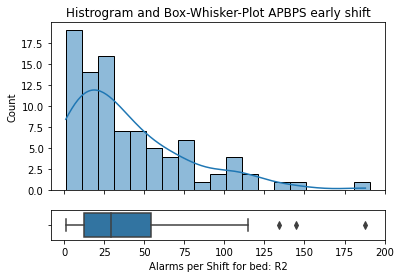

<Figure size 432x288 with 0 Axes>

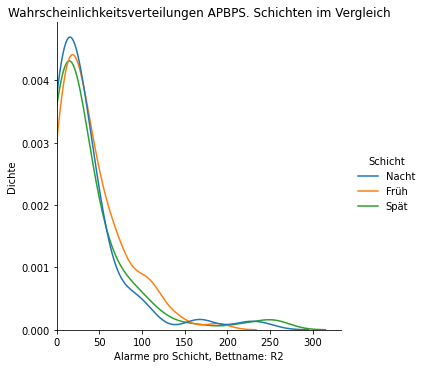

In [10]:
bed = "R2"

f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw = {"height_ratios": (.85, .15)})
sns.histplot(apbps[(apbps['Shift'] == 'Früh')], x=bed, kde = True, binwidth=10, ax = ax_hist)
ax_hist.set(ylabel = "Count", title = "Histrogram and Box-Whisker-Plot APBPS early shift")
sns.boxplot(x=bed, data=apbps[(apbps['Shift'] == 'Früh')], orient="h", ax = ax_box)
ax_box.set(xlabel = "Alarms per Shift for bed: {}".format(bed))
plt.figure()
ax = sns.displot(apbps[(apbps['Shift'] == 'Früh') | (apbps['Shift'] == 'Spät') | (
    apbps['Shift'] == 'Nacht')], x=bed, hue='Shift', kind='kde')
ax._legend.set_title("Schicht")
ax.set(xlabel = "Alarme pro Schicht, Bettname: {}".format(bed), ylabel = "Dichte", title = "Wahrscheinlichkeitsverteilungen APBPS. Schichten im Vergleich", xlim = (0, None))


In [11]:
bed = 'R2'
perc = apbps[(apbps['Shift'] == 'Früh') & (apbps[bed] == 0)][bed].shape[0] / apbps[apbps['Shift'] == 'Früh'][bed].shape[0]
print("{}% of entries are 0.".format(perc))
print("---------------------------------------------")
print("Description of APBPS during Frueh shift")
print(apbps[(apbps['Shift'] == 'Früh')][bed].describe())
print("---------------------------------------------")
print("trimmed mean\t{}".format(stats.trim_mean(apbps[(apbps['Shift'] == 'Früh')][bed], 0.1)))

del perc, bed

0.0% of entries are 0.
---------------------------------------------
Description of APBPS during Frueh shift
count     90.000000
mean      40.711111
std       37.545551
min        1.000000
25%       12.250000
50%       29.500000
75%       54.500000
max      188.000000
Name: R2, dtype: float64
---------------------------------------------
trimmed mean	34.94444444444444


# Proper Pause to Pause ratio (PP2PR)
Ein wenig aufwändiger zu berechnen ist die Metrik "Proper Pause To Pause Ratio" oder in deutsch"Verhältnis tatsächlicher Pausen zu allen Pausen". Dabei bezeichnen wir als tatsächliche Pause eine Pause die vom Stationspersonal beendet wurde oder eine Folge von kurz aufeinander folgenden ausgelaufenen Pausen mit eine tatsächlich beendeten Pause am Ende (Der Fall triff beispielsweise ein wenn Stationspersonal länger am Patienten arbeitet und die Alarme für diese Zeit ausstellt und am Ende der Intervention die Alarmpaus ehändisch deaktiviert).

In [12]:
def pp2pr_shift(df_slice):
    value = 0
    # Initializing variables to count amount of proper pauses and total amount of pauses
    properPauses = 0
    totalPauses = 0

    # Going through the slice entry by entry
    length = len(df_slice)
    i = 0
    while i < (length):
        # Count the amount of started Pauses in shift
        if df_slice['Alarmpause'].iloc[i] == 'Pause Ein':
            totalPauses += 1
            i += 1
            # continue outer while
            continue
        # count the proper pauses
        if df_slice['PausenDauer'].iloc[i] < 180:
            properPauses += 1
            i += 1
            # continue outer while
            continue
        # checking if non terminated pauses got extended
        elif df_slice['PausenDauer'].iloc[i] >= 180:
            # Setting timestamp to end of not properly terminated pause
            timestamp = pen.from_format(
                df_slice['TrueTime'].iloc[i], 'YYYY-MM-DD HH:mm:ss', tz='Europe/Berlin')
            # Setting lookup index to the last not properly finished pause if more than one is found
            lookup = i
            # Setting the search iterator one after lookup (since it is the one that triggered the long pause check)
            ite = lookup + 1
            #
            if ite >= length-1:
                i += 1
                # continue outer while
                continue
            # count amount of extensions
            amount = 0
            # While the timestamp of next log entry is in 180s range from the timestamp of last long pause to check
            while (timestamp.diff(pen.from_format(df_slice['TrueTime'].iloc[ite], 'YYYY-MM-DD HH:mm:ss', tz='Europe/Berlin')).in_seconds() < 180):
                # Searching for entries with same bed name and beginning pause -> canditate for extended proper pause
                if (df_slice['Bettname'].iloc[ite] == df_slice['Bettname'].iloc[lookup]) & (df_slice['Alarmpause'].iloc[ite] == 'Pause Ein'):
                    # Found a pause extension
                    amount += 1
                    #check if pause is finished properly or extended again -> searching for log entry where pause is terminated
                    # TODO insert check here to catch the right pause aus from the right bed
                    temp = df_slice.iloc[ite:, :]
                    temp = temp[temp['Bettname'] ==
                                df_slice['Bettname'].iloc[lookup]].iloc[:, :]
                    # No more entries in slice
                    if len(temp) == 0:
                        # break inner while
                        break
                    aus_idx = (temp['Alarmpause'] == 'Pause Aus').argmax()
                    # No termination found
                    if aus_idx == 0:
                        # break inner while
                        break
                    # termination found. Check if properly terminated
                    if ((temp['PausenDauer'].iloc[aus_idx] < 180)):
                        properPauses += amount
                        i = ite
                        break
                    # No proper termination but extension found
                    else:
                        lookup = ite + aus_idx
                        timestamp = pen.from_format(
                            df_slice['TrueTime'].iloc[lookup], 'YYYY-MM-DD HH:mm:ss', tz='Europe/Berlin')

                ite += 1
                if ite >= length:
                    # breaking inner while so no increment of i necessary
                    break
            # END inner while
        i += 1
        # END outer while

    if totalPauses != 0:
        value = (properPauses/totalPauses)
    else:
        value = np.nan

    return value


pp2pr_temp = []
# Filtering main dataset to a subset that holds all the data that we need
df_pp2pr = df[(df['PausenDauer'].notna()) | (df['Alarmpause'].notna())][['TrueTime', 'Schicht',
                                                                         'PausenDauer', 'Bettname', 'Alarmpause']].sort_values('TrueTime')
start_idx = 0
current_shift = df_pp2pr['Schicht'].iloc[0]
inc_idx = (df_pp2pr['Schicht'] != current_shift).argmax()
end_idx = (df_pp2pr['Schicht'] != current_shift).argmax()

while(inc_idx != 0):
    df_slice = df_pp2pr.iloc[start_idx:end_idx]
    pp2pr_temp.append(np.concatenate(
        ([current_shift, df_pp2pr['TrueTime'].iloc[start_idx], df_pp2pr['TrueTime'].iloc[end_idx-1]], [pp2pr_shift(df_slice)])))
    current_shift = df_pp2pr['Schicht'].iloc[end_idx]
    start_idx = end_idx
    inc_idx = (df_pp2pr['Schicht'].iloc[start_idx:] != current_shift).argmax()
    end_idx += inc_idx

# ENDE
df_slice = df_pp2pr.iloc[start_idx:]
pp2pr_temp.append(np.concatenate(
    ([current_shift, df_pp2pr['TrueTime'].iloc[start_idx], df_pp2pr['TrueTime'].iloc[-1]], [pp2pr_shift(df_slice)])))

pp2pr = pd.DataFrame(pp2pr_temp, columns=np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp', 'pp2pr']))
pp2pr['pp2pr'] = pp2pr['pp2pr'].astype(np.float64)
# Convert to percent
pp2pr['pp2pr'] = pp2pr['pp2pr']*100
print("PP2PR variables: {}".format(
    np.array(['Shift', 'FirstTimestamp', 'LastTimestamp', 'pp2pr'])))
del start_idx, inc_idx, end_idx, current_shift, df_slice, df_pp2pr, pp2pr_temp


PP2PR variables: ['Shift' 'FirstTimestamp' 'LastTimestamp' 'pp2pr']


## PP2PR: Plots and values
Auf den folgenden Plots zu sehen ist von oben nach unten das Histogramm der Metrik über alle Frühschichten im Datensatz (ingesamt 90 von 270 Schichten), der Whisker-Box-Plot dessen sogenannte Antennen (Whiskers) und blaue Box die Grenzen der Metrik anzeigen, das untere Quartil, den Median sowie das obere Quartil. Ausreißer werden mit als kleine Punkte außerhalb der Whisker gezeigt. Der letzte Plot vergleicht die approximierten Wahrscheinlichkeitsdichtefunktionen der drei Hauptschichten um ein gefühl dafür zu bekommen wie sich die Schichten untereinander verhalten bezüglich der Metrik

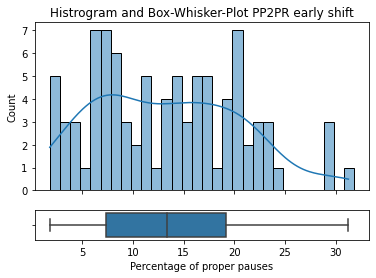

<Figure size 432x288 with 0 Axes>

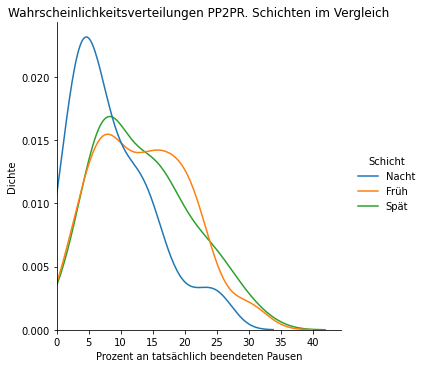

In [13]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw = {"height_ratios": (.85, .15)})
sns.histplot((pp2pr[(pp2pr['Shift'] == 'Früh')]), x='pp2pr', kde = True, binwidth=1, ax = ax_hist)
ax_hist.set(ylabel = "Count", title = "Histrogram and Box-Whisker-Plot PP2PR early shift")
sns.boxplot(x='pp2pr', data=(pp2pr[(pp2pr['Shift'] == 'Früh')]), orient="h", ax = ax_box)
ax_box.set(xlabel = "Percentage of proper pauses")
plt.figure()
ax = sns.displot((pp2pr[(pp2pr['Shift'] == 'Früh') | (pp2pr['Shift'] == 'Spät') | (
    pp2pr['Shift'] == 'Nacht')]), x='pp2pr', hue='Shift', kind='kde')
ax._legend.set_title("Schicht")
ax.set(xlabel = "Prozent an tatsächlich beendeten Pausen", ylabel = "Dichte", title = "Wahrscheinlichkeitsverteilungen PP2PR. Schichten im Vergleich", xlim = (0, None))



In [14]:
perc = pp2pr[(pp2pr['Shift'] == 'Früh') & (pp2pr['pp2pr'] == 0)]['pp2pr'].shape[0] / pp2pr[pp2pr['Shift'] == 'Früh']['pp2pr'].shape[0]
print("{}% of entries are 0.".format(np.round(perc*100, 2)))
print("---------------------------------------------")
print("Description of PP2PR during Frueh shift")
print(pp2pr[(pp2pr['Shift'] == 'Früh')]['pp2pr'].describe())
print("---------------------------------------------")
print("trimmed mean\t{}".format(stats.trim_mean(pp2pr[(pp2pr['Shift'] == 'Früh')]['pp2pr'], 0.1)))


0.0% of entries are 0.
---------------------------------------------
Description of PP2PR during Frueh shift
count    90.000000
mean     13.432381
std       7.160800
min       1.818182
25%       7.389979
50%      13.367698
75%      19.187561
max      31.250000
Name: pp2pr, dtype: float64
---------------------------------------------
trimmed mean	13.144503406236515


# Avoidable Alarms (AOTA)
Ebenfalls zu den einfachen Metriken zählend ist AOTA, Amount od technical alarms oder Anzahl technischer Alarme pro Schicht. Die Metrik stellt die Anzahl Technischer alarme dar die in einer Schicht generiert wurden

In [15]:
aota_temp = []

start_idx = 0
df_aota = df[(df['Alarmgruppe'] == 'Technical failure') & (df['Situation'] == 'generiert')][[
    'TrueTime', 'Schicht']].sort_values('TrueTime')
current_shift = df_aota['Schicht'].iloc[0]
inc_idx = (df_aota['Schicht'] != current_shift).argmax()
end_idx = (df_aota['Schicht'] != current_shift).argmax()

while(inc_idx != 0):
    df_slice = df_aota.iloc[start_idx:end_idx]
    value = df_slice.shape[0]
    aota_temp.append(np.concatenate(
        ([current_shift, df_aota['TrueTime'].iloc[start_idx], df_aota['TrueTime'].iloc[end_idx-1]], [value])))
    current_shift = df_aota['Schicht'].iloc[end_idx]
    start_idx = end_idx
    inc_idx = (df_aota['Schicht'].iloc[start_idx:] != current_shift).argmax()
    end_idx += inc_idx

df_slice = df_aota.iloc[start_idx:]
value = df_slice.shape[0]
aota_temp.append(np.concatenate(
    ([current_shift, df_aota['TrueTime'].iloc[start_idx], df_aota['TrueTime'].iloc[-1]], [value])))

aota = pd.DataFrame(aota_temp, columns=np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp', 'aota']))
aota['aota'] = aota['aota'].astype(np.int64)
print("AOTA variables: {}".format(
    np.array(['Shift', 'FirstTimestamp', 'LastTimestamp', 'aota'])))
del start_idx, inc_idx, end_idx, current_shift, df_slice, df_aota, aota_temp, value


AOTA variables: ['Shift' 'FirstTimestamp' 'LastTimestamp' 'aota']


## AOTA: Plots and values
Auf den folgenden Plots zu sehen ist von oben nach unten das Histogramm der Metrik über alle Frühschichten im Datensatz (ingesamt 90 von 270 Schichten), der Whisker-Box-Plot dessen sogenannte Antennen (Whiskers) und blaue Box die Grenzen der Metrik anzeigen, das untere Quartil, den Median sowie das obere Quartil. Ausreißer werden mit als kleine Punkte außerhalb der Whisker gezeigt. Der letzte Plot vergleicht die approximierten Wahrscheinlichkeitsdichtefunktionen der drei Hauptschichten um ein gefühl dafür zu bekommen wie sich die Schichten untereinander verhalten bezüglich der Metrik

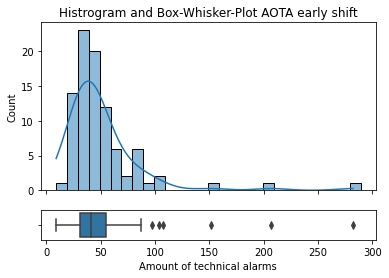

<Figure size 432x288 with 0 Axes>

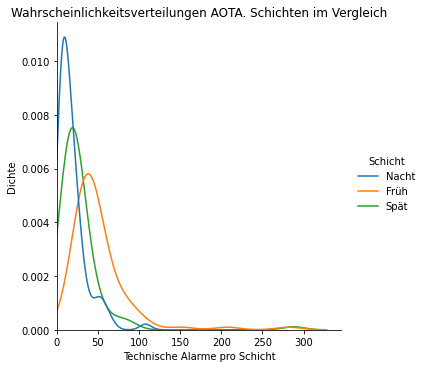

In [16]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw = {"height_ratios": (.85, .15)})
sns.histplot((aota[(aota['Shift'] == 'Früh')]), x='aota', kde = True, binwidth=10, ax = ax_hist)
ax_hist.set(ylabel = "Count", title = "Histrogram and Box-Whisker-Plot AOTA early shift")
sns.boxplot(x='aota', data=(aota[(aota['Shift'] == 'Früh')]), orient="h", ax = ax_box)
ax_box.set(xlabel = "Amount of technical alarms")
plt.figure()
ax = sns.displot((aota[(aota['Shift'] == 'Früh') | (aota['Shift'] == 'Spät') | (
    aota['Shift'] == 'Nacht')]), x='aota', hue='Shift', kind='kde')
ax._legend.set_title("Schicht")
ax.set(xlabel = "Technische Alarme pro Schicht", ylabel = "Dichte", title = "Wahrscheinlichkeitsverteilungen AOTA. Schichten im Vergleich", xlim = (0, None))

In [17]:
perc = aota[(aota['Shift'] == 'Früh') & (aota['aota'] == 0)]['aota'].shape[0] / aota[aota['Shift'] == 'Früh']['aota'].shape[0]
print("{}% of entries are 0.".format(np.round(perc*100, 2)))
print("---------------------------------------------")
print("Description of AOTA during Frueh shift")
print(aota[(aota['Shift'] == 'Früh')]['aota'].describe())
print("---------------------------------------------")
print("trimmed mean\t{}".format(stats.trim_mean(aota[(aota['Shift'] == 'Früh')]['aota'], 0.1)))

0.0% of entries are 0.
---------------------------------------------
Description of AOTA during Frueh shift
count     90.000000
mean      51.022222
std       37.381416
min        9.000000
25%       31.000000
50%       41.500000
75%       55.250000
max      282.000000
Name: aota, dtype: float64
---------------------------------------------
trimmed mean	44.166666666666664


# Seconds of concurrent alarms (SOCA)
Diese komplexe Metrik stellt die Anzahl an Sekunden einer Schicht dar, in denen mindestens 2 Alarme zeitgleich geläutet haben. Der verständlichkeit halber wird diese Metrik am Ende auch in Stunden umgerechnet da die Metrik sehr hohe Sekundenzahlen einnimmt.

In [18]:
# Cleaned SOCA
def register_overlap(overlap_list, current_overlap):
    l_idx = -1
    r_idx = -1
    for left_bound in reversed(range(len(overlap_list))):
        if (current_overlap[0] < overlap_list[left_bound][1]):
            l_idx = left_bound
    
    # Case 1: We did not find any overlaps of overlaps
    if l_idx == -1:
        overlap_list.append(current_overlap)
        return overlap_list
    # case 2: the current overlap overlaps all other overlaps, so we erase all and put in current one
    elif (l_idx == 0) & (current_overlap[0] < overlap_list[l_idx][0]):
        overlap_list = [current_overlap]
        return overlap_list
    # Case 3: current overlapt interval overlaps with any overlap interval
    # So we throw everything up to the point of the exact overlap and append the current
    else:
        if current_overlap[0] < overlap_list[l_idx][0]:
            overlap_list = overlap_list[:l_idx]
            overlap_list.append(current_overlap)
        else:

            temp = [overlap_list[l_idx][0], current_overlap[0], current_overlap[0].diff(
                overlap_list[l_idx][0]).in_seconds()]
            overlap_list = overlap_list[:l_idx+1]
            overlap_list[l_idx] = temp
            overlap_list.append(current_overlap)

    return overlap_list

def get_overlaps(alarms, current):
    overlaps = []
    for k in range(len(alarms)):
        if current[0] < alarms[k][0]:
            overlaps = register_overlap(overlaps, alarms[k])
        else:
            overlaps = register_overlap(overlaps, [current[0], alarms[k][1], current[0].diff(alarms[k][1]).in_seconds()])
    return overlaps

def soca_shift(df_slice):
    # Iterate through the slice and do: Truetime - Zeitdifferenz = alarm_starttime. Check if starttime is before endtime from previous entries
    # we can erase shift_timeline and use df_slice instead
    shift_timeline = []
    # concurrent alarms timeline
    overlaps_total = []
    for i in range(df_slice.shape[0]):
        # create pendulum dateTime instances and compute start time of alarm
        end_time = pen.from_format(
            df_slice['TrueTime'].iloc[i], 'YYYY-MM-DD HH:mm:ss', tz='Europe/Berlin')
        start_time = end_time.subtract(
            seconds=df_slice['Zeitdifferenz'].iloc[i])
        shift_timeline.append(
            [start_time, end_time, df_slice['Zeitdifferenz'].iloc[i]])
        # Preparing tuple to register last alarm
        last_overlap_tup = [0, 0, 0]
        # Collecting list of alarms that end inside of the bounds of the current alarms
        alarms = []
        # going through all shift timeline entries to see if starttime from current alarm is earlier than previous ending times
        for j in reversed(range(i)):
            if start_time < shift_timeline[j][1]:
                last_overlap_tup = shift_timeline[j]
                alarms.append(shift_timeline[j])
            # if the first entry right before the current one ends before the current starts, we quit since the rest is earlier too
            if ((last_overlap_tup[0] == 0)):
                break
        # We found at least one overlap
        if(last_overlap_tup[0] != 0):
            alarms = np.flip(alarms, axis = 0)
            overlaps = get_overlaps(alarms, shift_timeline[-1])
            
            # check and register overlap. We dont want to count overlapping overlap seconds more than once
            
            if len(overlaps_total) == 0:
                for overlap in overlaps:
                    overlaps_total.append(overlap)
            else:
                for overlap in overlaps:
                    overlaps_total = register_overlap(overlaps_total, overlap)

    # count seconds
    result = 0
    for i in range(len(overlaps_total)):
        #result += overlap_timeline[i][2]
        result += int(overlaps_total[i][2])
    #print("CUMU {}".format(cumu))
    return result


duration_thr = 1500  # Threshold to cut off alarm durations that are longer than 25 minutes. What threshold should be considered?
soca_temp = []

start_idx = 0
df_soca = df[df['Zeitdifferenz'].notna()][['TrueTime', 'Schicht',
                                           'Zeitdifferenz']].sort_values('TrueTime')
df_soca = df_soca[(df_soca['Zeitdifferenz'] > 0) & (
    df_soca['Zeitdifferenz'] <= duration_thr)][:]
current_shift = df_soca['Schicht'].iloc[0]
inc_idx = (df_soca['Schicht'] != current_shift).argmax()
end_idx = (df_soca['Schicht'] != current_shift).argmax()

while(inc_idx != 0):
    df_slice = df_soca[['TrueTime', 'Zeitdifferenz']].iloc[start_idx:end_idx]
    soca_temp.append(np.concatenate(
        ([current_shift, df_soca['TrueTime'].iloc[start_idx], df_soca['TrueTime'].iloc[end_idx-1]], [soca_shift(df_slice)])))
    current_shift = df_soca['Schicht'].iloc[end_idx]
    start_idx = end_idx
    inc_idx = (df_soca['Schicht'].iloc[start_idx:] != current_shift).argmax()
    end_idx += inc_idx

df_slice = df_soca[['TrueTime', 'Zeitdifferenz']].iloc[start_idx:]
soca_temp.append(np.concatenate(
    ([current_shift, df_soca['TrueTime'].iloc[start_idx], df_soca['TrueTime'].iloc[-1]], [soca_shift(df_slice)])))
soca = pd.DataFrame(soca_temp, columns=np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp', 'soca']))
soca['soca'] = soca['soca'].astype(np.int64)
hoca = soca
hoca = hoca.rename(columns = {"soca": "hoca"})
hoca['hoca'] = hoca['hoca']/60/60
print("SOCA variables: {}".format(
    np.array(['Shift', 'FirstTimestamp', 'LastTimestamp', 'soca'])))
del start_idx, inc_idx, end_idx, current_shift, df_slice, df_soca, soca_temp, duration_thr


SOCA variables: ['Shift' 'FirstTimestamp' 'LastTimestamp' 'soca']


## SOCA Plots and Values
Auf den folgenden Plots zu sehen ist von oben nach unten das Histogramm der Metrik über alle Frühschichten im Datensatz (ingesamt 90 von 270 Schichten), der Whisker-Box-Plot dessen sogenannte Antennen (Whiskers) und blaue Box die Grenzen der Metrik anzeigen, das untere Quartil, den Median sowie das obere Quartil. Ausreißer werden mit als kleine Punkte außerhalb der Whisker gezeigt. Der letzte Plot vergleicht die approximierten Wahrscheinlichkeitsdichtefunktionen der drei Hauptschichten um ein gefühl dafür zu bekommen wie sich die Schichten untereinander verhalten bezüglich der Metrik

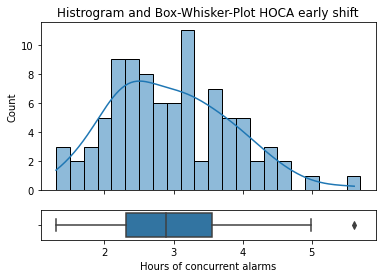

<Figure size 432x288 with 0 Axes>

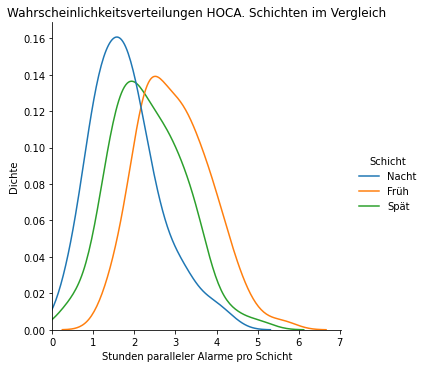

In [19]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw = {"height_ratios": (.85, .15)})
sns.histplot(hoca[(hoca['Shift'] == 'Früh')], x='hoca', kde = True, binwidth=0.2, ax = ax_hist)
ax_hist.set(ylabel = "Count", title = "Histrogram and Box-Whisker-Plot HOCA early shift")
sns.boxplot(x='hoca', data=hoca[(hoca['Shift'] == 'Früh')], orient="h", ax = ax_box)
ax_box.set(xlabel = "Hours of concurrent alarms")
plt.figure()
ax = sns.displot(hoca[(hoca['Shift'] == 'Früh') | (hoca['Shift'] == 'Spät') | (
    hoca['Shift'] == 'Nacht')], x='hoca', hue='Shift', kind='kde')
ax._legend.set_title("Schicht")
ax.set(xlabel = "Stunden paralleler Alarme pro Schicht", ylabel = "Dichte", title = "Wahrscheinlichkeitsverteilungen HOCA. Schichten im Vergleich", xlim = (0, None))

In [20]:
perc = hoca[(hoca['Shift'] == 'Früh') & (hoca['hoca'] == 0)]['hoca'].shape[0] / hoca[hoca['Shift'] == 'Früh']['hoca'].shape[0]
print("{}% of entries are 0.".format(np.round(perc*100, 2)))
print("---------------------------------------------")
print("Description of SOCA during Frueh shift")
print(hoca[(hoca['Shift'] == 'Früh')]['hoca'].describe())
print("---------------------------------------------")
print("trimmed mean\t{}".format(stats.trim_mean(hoca[(hoca['Shift'] == 'Früh')]['hoca'], 0.1)))
del perc

0.0% of entries are 0.
---------------------------------------------
Description of SOCA during Frueh shift
count    90.000000
mean      2.969929
std       0.864463
min       1.301667
25%       2.320000
50%       2.891667
75%       3.557986
max       5.611944
Name: hoca, dtype: float64
---------------------------------------------
trimmed mean	2.9312692901234567


in 2 phasen workshop. erst intern mit P sina sophie und danach erst mit stationspersonal

# Alarm flood conditions per shift (AFCPS)
After creating the data frame containing the metric we will be taking a first look into our computed data by plotting it and computing descriptive statistics

TODO: Plots beschriften (Axen) und werte einzeichnen sowei titel einfügen und als png speichern

In [21]:
def afcps_shift(df_slice):
    value = 0
    length = len(df_slice)
    i = 0
    while i < length:
        it = 1
        start_time = pen.from_format(
            df_slice['TrueTime'].iloc[i], 'YYYY-MM-DD HH:mm:ss', tz='Europe/Berlin')
        if (i + it) >= length - 1:
            i += 1
            continue
        while start_time.diff(pen.from_format(
                df_slice['TrueTime'].iloc[i+it], 'YYYY-MM-DD HH:mm:ss', tz='Europe/Berlin')).in_seconds() <= 600:
            it += 1
            if (i+it) == length-1:
                break

        if it >= 10:
            value += 1
            i += (it)
        else: i += 1
    return value


afcps_temp = []

start_idx = 0
df_afcps = df[df['Situation'] == 'generiert'][['TrueTime', 'Schicht',
                                               'Situation']].sort_values('TrueTime')
current_shift = df_afcps['Schicht'].iloc[0]
inc_idx = (df_afcps['Schicht'] != current_shift).argmax()
end_idx = (df_afcps['Schicht'] != current_shift).argmax()

while(inc_idx != 0):
    df_slice = df_afcps[['TrueTime', 'Situation']].iloc[start_idx:end_idx]
    afcps_temp.append(np.concatenate(
        ([current_shift, df_afcps['TrueTime'].iloc[start_idx], df_afcps['TrueTime'].iloc[end_idx-1]], [afcps_shift(df_slice)])))
    current_shift = df_afcps['Schicht'].iloc[end_idx]
    start_idx = end_idx
    inc_idx = (df_afcps['Schicht'].iloc[start_idx:] != current_shift).argmax()
    end_idx += inc_idx

df_slice = df_afcps[['TrueTime', 'Situation']].iloc[start_idx:]
afcps_temp.append(np.concatenate(
    ([current_shift, df_afcps['TrueTime'].iloc[start_idx], df_afcps['TrueTime'].iloc[-1]], [afcps_shift(df_slice)])))

afcps = pd.DataFrame(afcps_temp, columns=np.array(
    ['Shift', 'FirstTimestamp', 'LastTimestamp', 'afcps']))
afcps['afcps'] = afcps['afcps'].astype(np.int64)
print("SOCA variables: {}".format(
    np.array(['Shift', 'FirstTimestamp', 'LastTimestamp', 'afcps'])))
del start_idx, inc_idx, end_idx, current_shift, df_slice, df_afcps, afcps_temp


## AFCPS Plots and Values
Auf den folgenden Plots zu sehen ist von oben nach unten das Histogramm der Metrik über alle Frühschichten im Datensatz (ingesamt 90 von 270 Schichten), der Whisker-Box-Plot dessen sogenannte Antennen (Whiskers) und blaue Box die Grenzen der Metrik anzeigen, das untere Quartil, den Median sowie das obere Quartil. Ausreißer werden mit als kleine Punkte außerhalb der Whisker gezeigt. Der letzte Plot vergleicht die approximierten Wahrscheinlichkeitsdichtefunktionen der drei Hauptschichten um ein gefühl dafür zu bekommen wie sich die Schichten untereinander verhalten bezüglich der Metrik

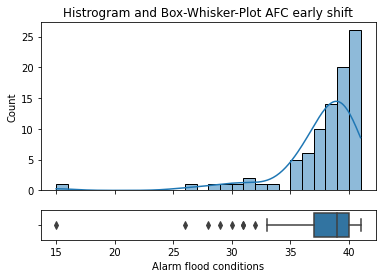

<Figure size 432x288 with 0 Axes>

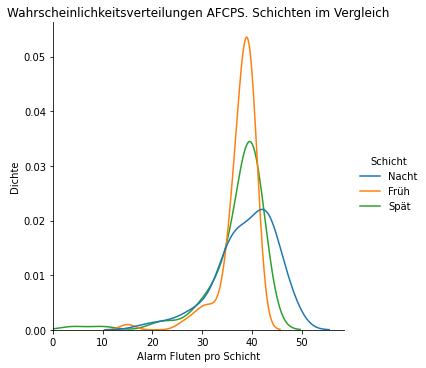

In [ ]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw = {"height_ratios": (.85, .15)})
sns.histplot(afcps[(afcps['Shift'] == 'Früh')], x='afcps', kde = True, binwidth=1, ax = ax_hist)
ax_hist.set(ylabel = "Count", title = "Histrogram and Box-Whisker-Plot AFC early shift")
sns.boxplot(x='afcps', data=afcps[(afcps['Shift'] == 'Früh')], orient="h", ax = ax_box)
ax_box.set(xlabel = "Alarm flood conditions")
plt.figure()
ax = sns.displot(afcps[(afcps['Shift'] == 'Früh') | (afcps['Shift'] == 'Spät') | (
    afcps['Shift'] == 'Nacht')], x='afcps', hue='Shift', kind='kde')
ax._legend.set_title("Schicht")
ax.set(xlabel = "Alarm Fluten pro Schicht", ylabel = "Dichte", title = "Wahrscheinlichkeitsverteilungen AFCPS. Schichten im Vergleich", xlim = (0, None))

In [ ]:
perc = afcps[(afcps['Shift'] == 'Früh') & (afcps['afcps'] == 0)]['afcps'].shape[0] / afcps[afcps['Shift'] == 'Früh']['afcps'].shape[0]
print("{}% of entries are 0.".format(np.round(perc*100, 2)))
print("---------------------------------------------")
print("Description of AFCPS during Frueh shift")
print(afcps[(afcps['Shift'] == 'Früh')]['afcps'].describe())
print("---------------------------------------------")
print("trimmed mean\t{}".format(stats.trim_mean(afcps[(afcps['Shift'] == 'Früh')]['afcps'], 0.1)))

0.0% of entries are 0.
---------------------------------------------
Description of AFCPS during Frueh shift
count    90.000000
mean     37.477778
std       3.793039
min      15.000000
25%      37.000000
50%      39.000000
75%      40.000000
max      41.000000
Name: afcps, dtype: float64
---------------------------------------------
trimmed mean	38.236111111111114
